In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the data saved in local downloaded from Amazon S3
inventory = pd.read_parquet('../../../data-zrive-ds/sampled-datasets/inventory.parquet')
abandoned_carts = pd.read_parquet('../../../data-zrive-ds/sampled-datasets/abandoned_carts.parquet')
orders = pd.read_parquet('../../../data-zrive-ds/sampled-datasets/orders.parquet')
regulars = pd.read_parquet('../../../data-zrive-ds/sampled-datasets/regulars.parquet')
users = pd.read_parquet('../../../data-zrive-ds/sampled-datasets/users.parquet')

## Part 1

The data is partitioned over multiple datasets and comes from a groceries e-
commerce platform selling products directly to consumers (think of it as an online
supermarket):

- **orders**: An order history of customers. Each row is an order and the
item_ids for the order are stored as a list in the item_ids column.

- **regulars**: Users are allowed to specify items that they wish to buy
regularly. This data gives the items each user has asked to get regularly, along
with when they input that information.

- **abandoned_cart**: If a user has added items to their basket but not
bought them, we capture that information. Items that were abandoned are stored
as a list in item_ids.

- **inventory**: Some information about each item_id.

- **users**: Information about users.


### EDA STEPS:
1. First we will check each of the tables we will be working with in order to understand deeply the information. Then we can start thinking about creating hypothesis.

2. We now look for null values, weird outliers and make sure our data is OK. Then we make decisions and justify why we impute values or delete certain features/rows.

3. Once cleaned, we join tables and create new features.

4. We test the hypothesis we created.


### Inventory
Info about each item id

In [3]:
inventory.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [4]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


No null data in inventory

### Abandoned Carts
If a user has added items to their basket but not
bought them, we capture that information. Items that were abandoned are stored
as a list in item_ids.

In [5]:
abandoned_carts.head()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


In [6]:
abandoned_carts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB


No null data in abandoned_carts. Weird indexes, it's probably a sample of the whole dataset.

### Orders
An order history of customers. Each row is an order and the
items ids of each order are stored in a list in the ordered_items column.

In [7]:
orders.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


The orders dataset is probably also a sample. No null data.

### Regulars
Users are allowed to specify items that they wish to buy
regularly. This data contains the items each user has asked to get regularly, along with the date when they input that information.

In [9]:
regulars.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


In [10]:
regulars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


regulars is also a sample. No null data.

### Users
Info about users

In [11]:
users.head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


Users contains interesting data. Nuts are a way of dividing the UK in small and similar sized regions. Many null values in the 'count' categories. If this data comes from optional answers we may be taking some risk of skewing heavily our sample. Again, we can guess this is a sample based on the indexes.

There are also less nuts than user ids, so some people don't have any nut assigned. 

Let's get some info about our missing values

In [13]:
users.isnull().sum()

user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64

In [14]:
users[['user_nuts1', 'count_people','count_adults', 'count_children', 'count_babies', 'count_pets']].describe()

,count_people,count_adults,count_children,count_babies,count_pets
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923
std,1.365753,0.869577,1.026246,0.289086,0.995603
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000


In [15]:
for col in users.columns[5:]:
    print(users[col].value_counts())

count_people
2.0    97
3.0    68
4.0    67
1.0    57
5.0    24
6.0     8
0.0     2
7.0     1
8.0     1
Name: count, dtype: int64
count_adults
2.0    201
1.0     71
3.0     32
4.0     11
5.0      5
0.0      3
7.0      1
6.0      1
Name: count, dtype: int64
count_children
0.0    195
2.0     58
1.0     55
3.0     12
4.0      3
5.0      1
6.0      1
Name: count, dtype: int64
count_babies
0.0    302
1.0     21
2.0      2
Name: count, dtype: int64
count_pets
0.0    193
1.0     87
2.0     28
3.0      8
4.0      6
5.0      2
6.0      1
Name: count, dtype: int64


I'm guessing these columns were created as extra info added voluntarily by clients and that's the reason why we have so many missing values. We can keep these features as they can provide some insights in the future.

In [16]:
users[users['user_nuts1'].isnull()].head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
1145,8afa3289c56fd4225f42bd3427615204eca9fea9e46261...,Top Up,None,2021-09-27 16:42:50,2021-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1858,361235e2decd78440db688cc8ca0abf6ec6725dd5a2e6c...,Proposition,None,2021-11-26 13:19:47,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
3884,e99c9a29e3d1fc49649568cc5625a23b2aa8e3a4577527...,Top Up,None,2022-02-21 12:50:19,2022-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4573,e5ff40c78b3cdcf2b10c9dc69e5e893d95246741300f26...,Proposition,None,2020-05-30 13:28:27,2020-05-01 00:00:00,4.0,3.0,1.0,0.0,2.0
12992,b34e8a5c1464868734143e3e3b49d951e8dc7efb346852...,Proposition,None,2021-05-23 17:56:47,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN


We also have 51 users with no nut info. We will also keep this data by now.

## Joining Tables
We are going to join **orders** and **inventory** tables on variant_id indexes ('variant_ids' are contained in 'ordered_items' lists in the orders table). By doing so, we will be able to analyze the categories and tags of the products that are being ordered. We can also check if we have products in the inventory that aren't being sold.

In [17]:
'''we break down each list 'ordered_items' into different rows.
Then we reset the indexes'''

orders_split = orders.explode('ordered_items').reset_index(drop=True)
orders_split.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828
1,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588
2,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452
3,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060
4,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060


In [18]:
print(f" Number of orders: {len(orders)}\n Total products bought: {len(orders_split)}\n Average number of items per order: {(len(orders_split)/len(orders)):.2f}")

 Number of orders: 8773
 Total products bought: 107958
 Average number of items per order: 12.31


### How should we join the tables?
We have to think first about the questions each join could answer.

1. *Inner Join*: We would have only the items that are available in inventory *AND* have been ordered. It is useful because by checking the length of this table we can know how many of the items in inventory are being sold.

2. *Left Join* (on inventory): We now preserve all the rows in inventory and complete them with the info of the orders of these products that exist. Do we have products in our inventory that have never been ordered? We can answer this question looking for empty values in the orders-related columns.

3. *Right Join* (on orders): We now keep the rows in orders and fill them with info from inventory. Do we have products that have been ordered but don't exist in our inventory? In that case we need to look for empty values in the inventory-related columns. If that was the case this can mean two things: we don't have the item in our inventory yet or it could be an error (mistaken register).

4. *Outer Join*: We keep all the data. We have a whole vision of our data.

In [19]:
inner = inventory.merge(orders_split, how='inner', left_on='variant_id', right_on='ordered_items')
inventory_complete = inventory.merge(orders_split, how='left', left_on='variant_id', right_on='ordered_items')
orders_complete = inventory.merge(orders_split, how='right', left_on='variant_id', right_on='ordered_items')
inventory_or_orders = inventory.merge(orders_split, how='outer', left_on='variant_id', right_on='ordered_items')

In [50]:

print(f"Total orders: {len(orders)}")
print(f"Volume of existing inventory items ordered: {len(inner)}")
print(f"Items in inventory that have NEVER been ordered: {len(inventory_complete) - len(inner)}")
print(f"Volume of items ordered: {len(orders_complete)}")
print(f"Unique items in inventory: {len(inventory)}")
print(f"Unique items ordered: {orders_complete['ordered_items'].nunique()}")
print(f"Number of existing items in inventory or ordered: {len(inventory_or_orders)}")

Total orders: 8773
Volume of existing inventory items ordered: 92361
Items in inventory that have NEVER been ordered: 256
Volume of items ordered: 107958
Unique items in inventory: 1733
Unique items ordered: 2117
Number of existing items in inventory or ordered: 108214


I'm going to stop with the tables since it is a rabbit hole. I'm going to focus on analyzing our sales. So I will be working with inventory_complete from now on.

In [51]:
inventory_complete.head()

,variant_id,price,compare_at_price,vendor,product_type,tags,id,user_id,created_at,order_date,user_order_seq,ordered_items
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.297562e+12,70741713dc3d0ca898200632ca4fb44f5105416d0d66a7...,2020-06-12 00:00:29,2020-06-11,1.0,39587297165444
1,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.302065e+12,b2cc7053eea2abd9033fb47469ac0e29c5deb2752b43a2...,2020-06-16 14:55:56,2020-06-16,1.0,39587297165444
2,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.304104e+12,5e662d203c16c72443d1f97e6a29604a7fb0c8ae836cd7...,2020-06-18 16:38:36,2020-06-18,1.0,39587297165444
3,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.322977e+12,1e29453f19121f338edd09ac8d0bfc6431883377d39241...,2020-07-02 14:57:26,2020-07-02,1.0,39587297165444
4,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.326898e+12,9155c7d1ea2729fd64fd9243afd4c347e7a1b65c2b4302...,2020-07-07 13:59:15,2020-07-07,2.0,39587297165444


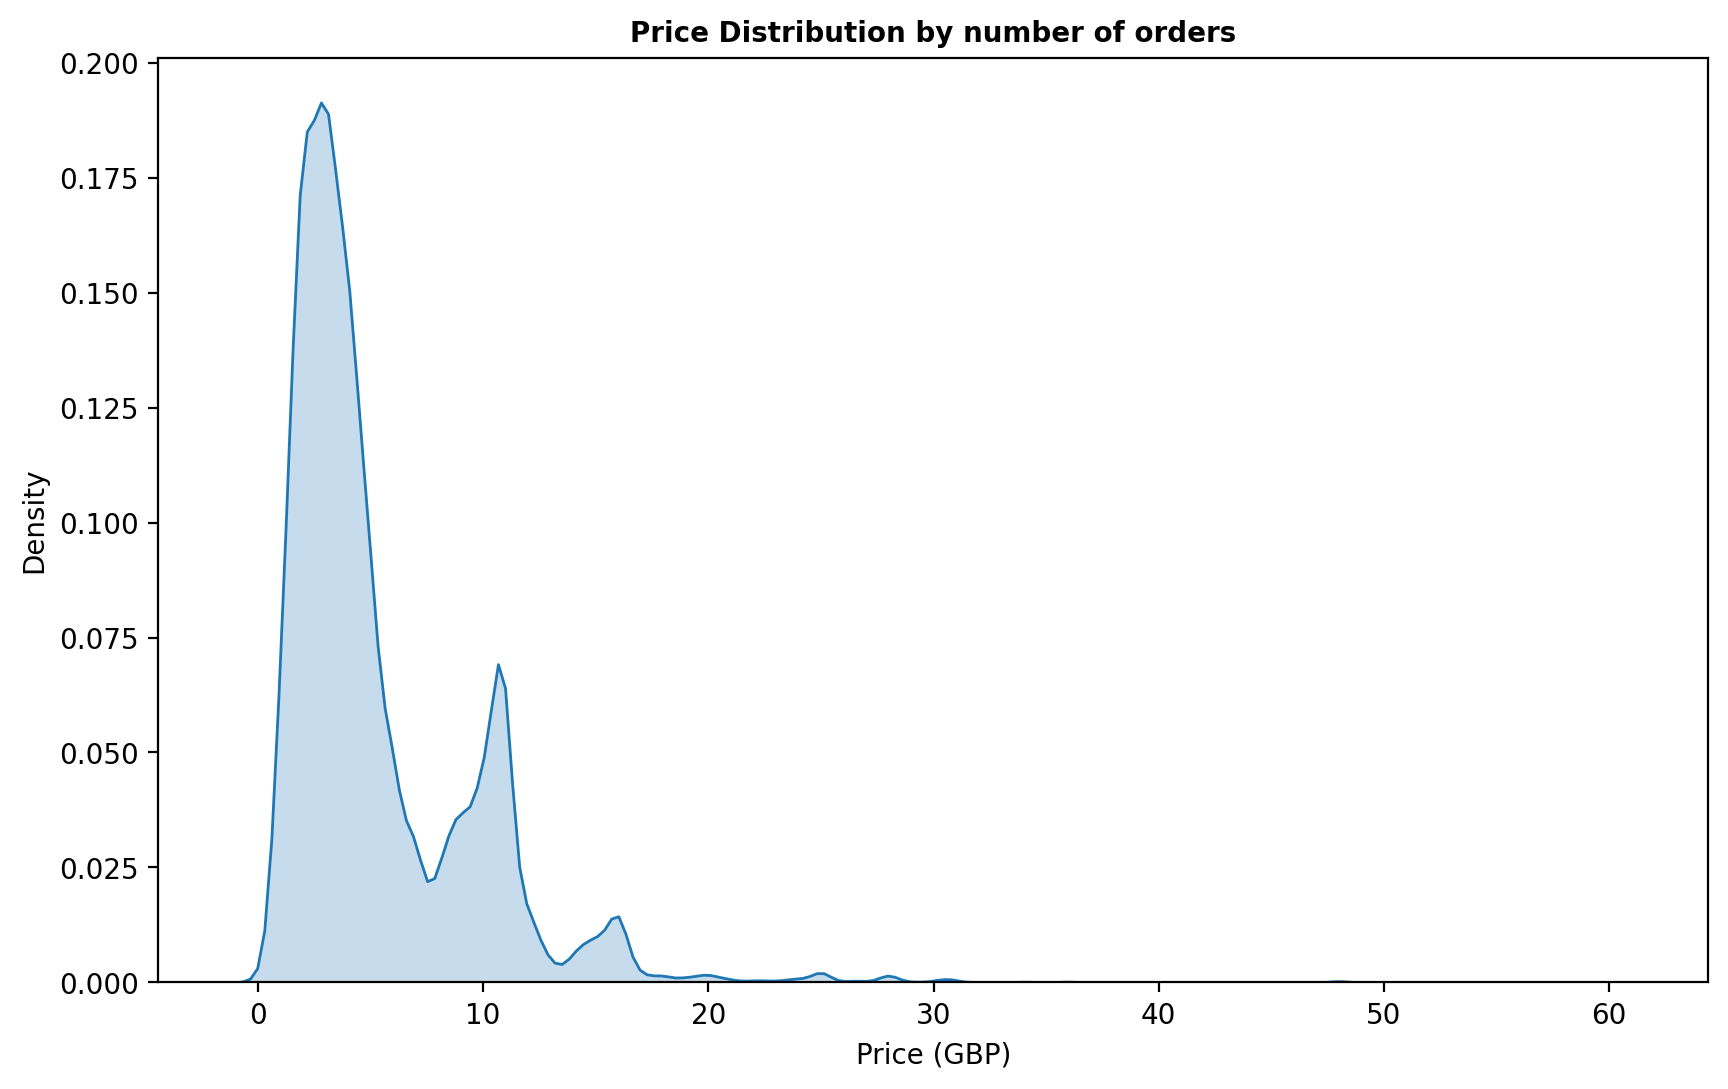

In [54]:
plt.figure(figsize=(10,6),dpi=200)
sns.kdeplot(data = inventory_complete, x='price',fill=True)
plt.xlabel("Price (GBP)")
plt.ylabel("Density")
plt.title('Price Distribution by number of orders',fontsize =10,fontweight = 'bold')

plt.show()


Watching the distribution of prices by the amount of orders received, we can see that most of our sold products are relatively cheap (0-5 GBP) but we are also getting a lot of sales in the 10-13 GBP range.

What are our most sold products?

In [56]:
inventory_complete.head()

,variant_id,price,compare_at_price,vendor,product_type,tags,id,user_id,created_at,order_date,user_order_seq,ordered_items
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.297562e+12,70741713dc3d0ca898200632ca4fb44f5105416d0d66a7...,2020-06-12 00:00:29,2020-06-11,1.0,39587297165444
1,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.302065e+12,b2cc7053eea2abd9033fb47469ac0e29c5deb2752b43a2...,2020-06-16 14:55:56,2020-06-16,1.0,39587297165444
2,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.304104e+12,5e662d203c16c72443d1f97e6a29604a7fb0c8ae836cd7...,2020-06-18 16:38:36,2020-06-18,1.0,39587297165444
3,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.322977e+12,1e29453f19121f338edd09ac8d0bfc6431883377d39241...,2020-07-02 14:57:26,2020-07-02,1.0,39587297165444
4,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]",2.326898e+12,9155c7d1ea2729fd64fd9243afd4c347e7a1b65c2b4302...,2020-07-07 13:59:15,2020-07-07,2.0,39587297165444


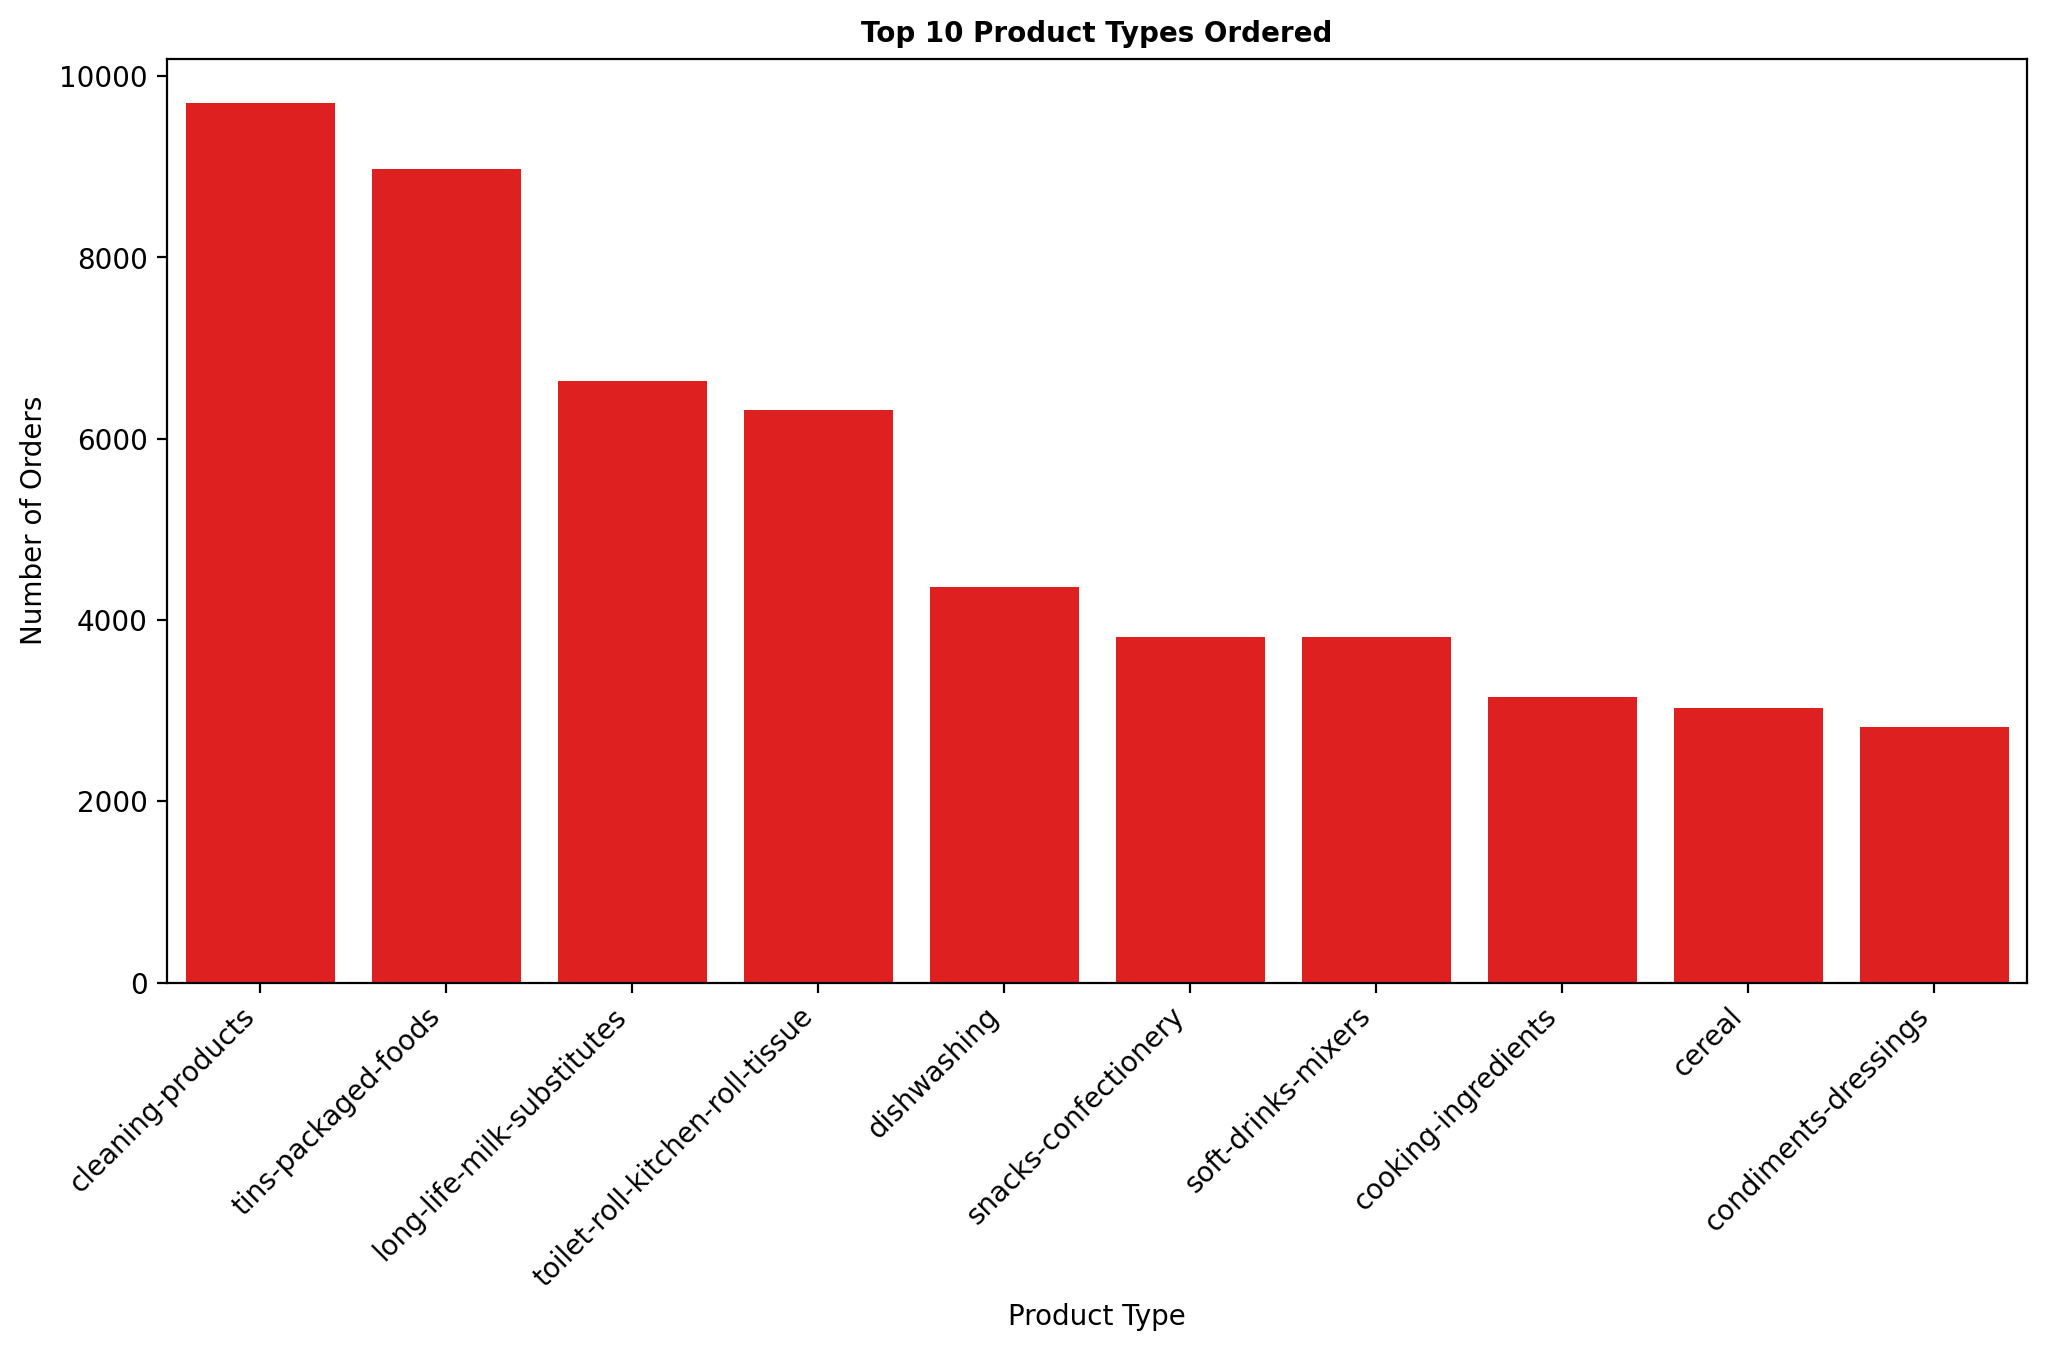

In [83]:
# We get the top 10 sales
top_10_sales = inventory_complete['product_type'].value_counts()[:10]

plt.figure(figsize=(12, 6), dpi=200)
sns.countplot(data = inventory_complete, x='product_type', order=top_10_sales.index, color='red')
plt.xlabel('Product Type')
plt.ylabel('Number of Orders')
plt.title('Top 10 Product Types Ordered', fontsize =10, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')  # Rotate xf axis tags
plt.show()


Our most sold products are cleaning products, packaged food and milk substitutes, reinforcing the idea that our e-commerce is specialized in vegan-eco products.

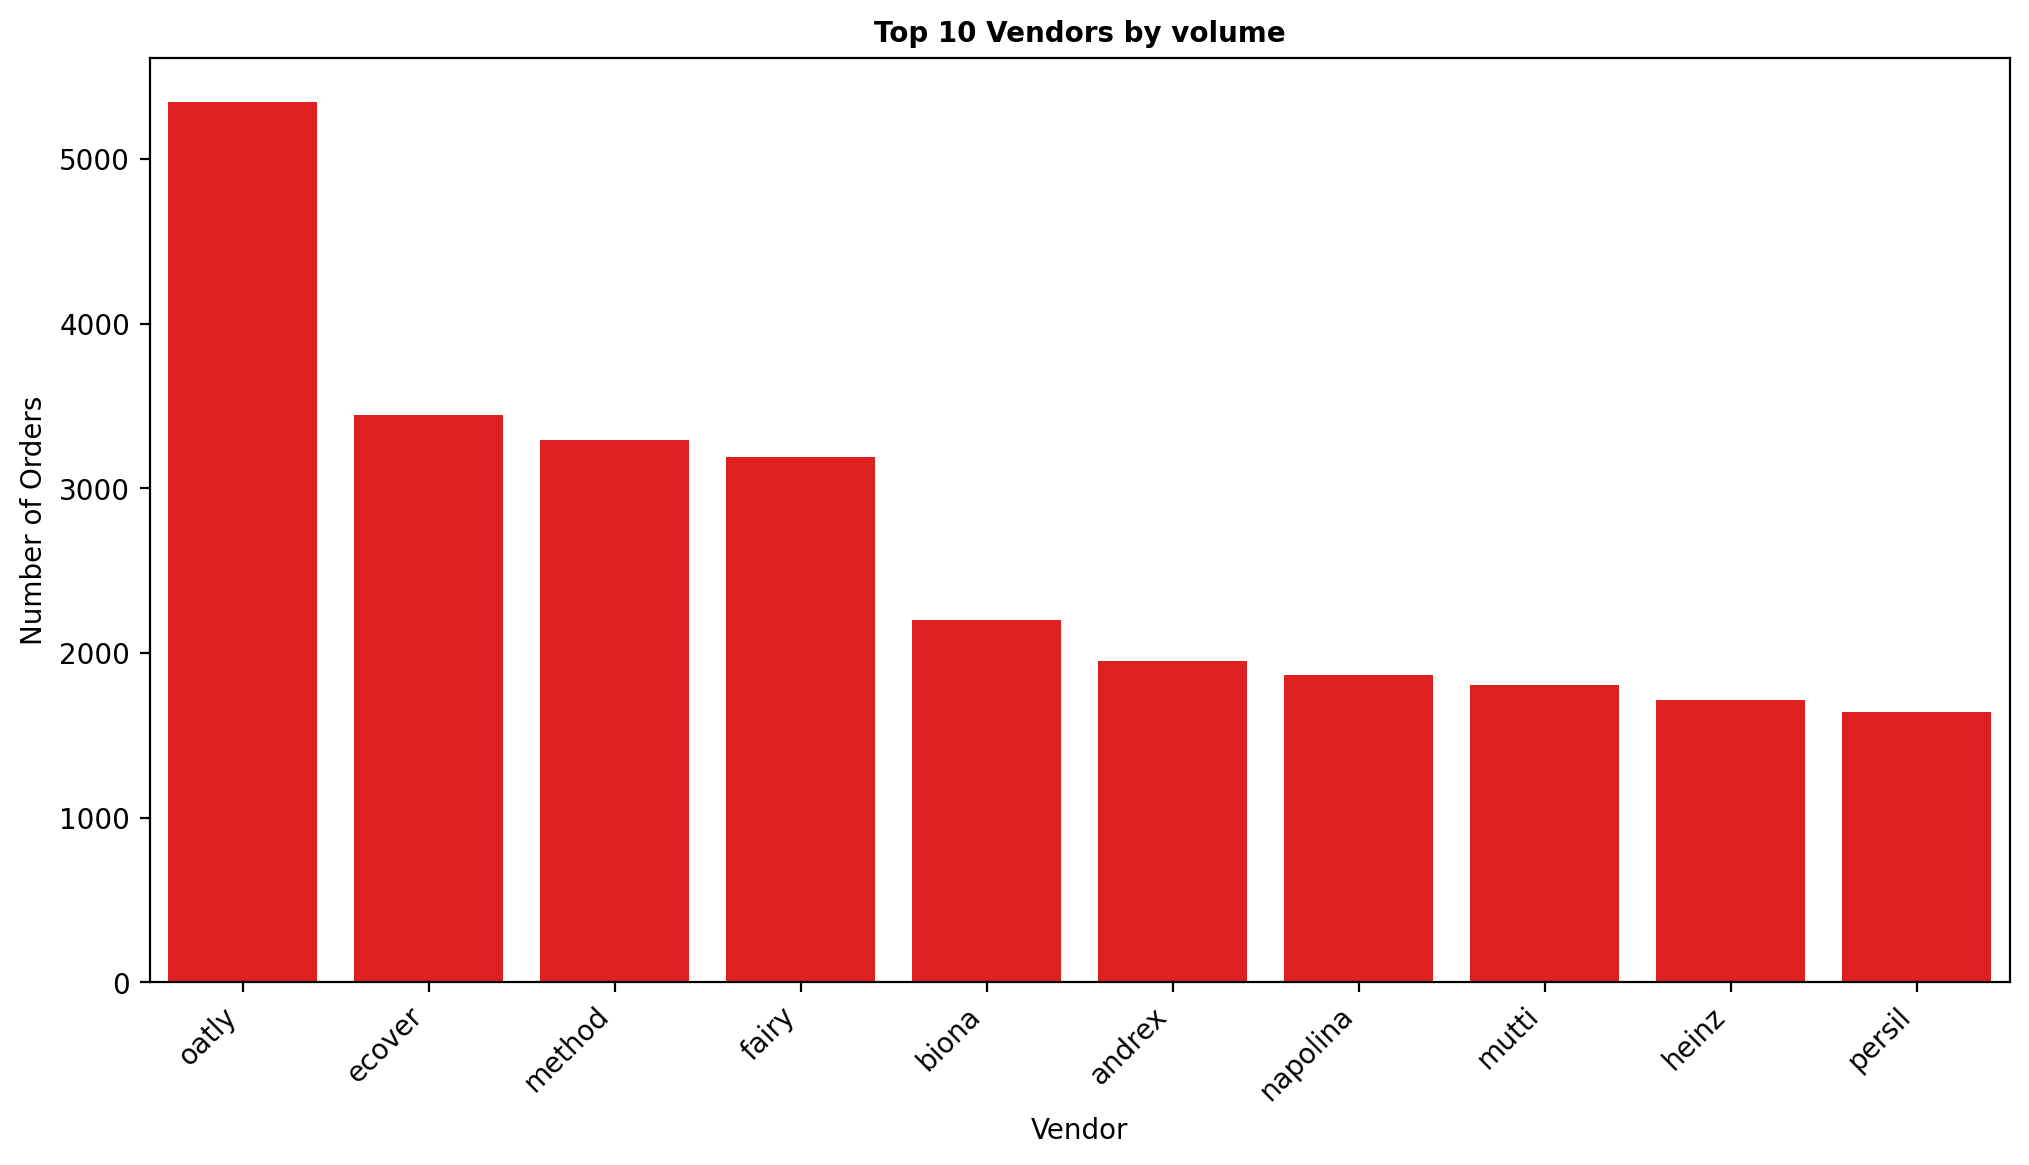

In [88]:
# We get the top 10 vendors
top_10_vendors = inventory_complete['vendor'].value_counts()[:10]

plt.figure(figsize=(12, 6), dpi=200)
sns.countplot(data = inventory_complete, x='vendor', order=top_10_vendors.index, color='red')
plt.xlabel('Vendor')
plt.ylabel('Number of Orders')
plt.title('Top 10 Vendors by volume', fontsize =10, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')  # Rotate xf axis tags
plt.show()

We found again more evidence in favor of our hypothesis that we are a e-commerce specialized in eco and vegan products as our top vendors are oatly (oat milk) and ecover (eco laundry).

It would be interesting comparing vendors by volume and by facturation.

In [100]:
# Top 10 vendors by facturation
inventory_complete.groupby('vendor')['price'].sum().sort_values(ascending=False).head(10)

vendor
oatly       56344.15
ecover      25014.45
persil      21307.60
fairy       19246.51
method      13923.57
andrex      13365.09
biona       10203.12
cocacola     8630.23
ariel        8534.76
alpro        6580.90
Name: price, dtype: float64

We have slight differences. Persil (detergent) comes third in facturation and CocaCola appears at top 8 (meaning people spend more money while buying less items of these vendors). But not many differences overall.

In [116]:
inventory_complete[['price', 'product_type']].drop_duplicates().sort_values(by='price').iloc[-5:]

,price,product_type
90151,47.99,haircare
89501,48.99,skincare
91691,49.99,mixed-bundles
92463,49.99,superfoods-supplements
90009,59.99,baby-kids-toiletries


Are these kind of insights really useful? Decide before continuing...

In [ ]:
# We get the top 5 most expensive products
top_5_expensive = inventory_complete['price'].drop_duplicates().sort_values(by='price')

plt.figure(figsize=(12, 6), dpi=200)
sns.countplot(data = inventory_complete, x='vendor', order=top_10_vendors.index, color='red')
plt.xlabel('Vendor')
plt.ylabel('Number of Orders')
plt.title('Top 10 Vendors by volume', fontsize =10, fontweight = 'bold')
plt.xticks(rotation=45, ha='right')  # Rotate xf axis tags
plt.show()

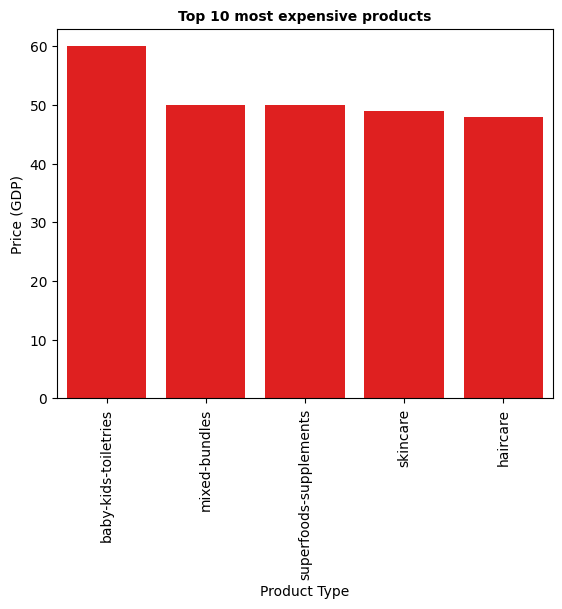

In [84]:
sns.barplot(data= inventory_complete.sort_values(by='price', ascending=False).head(10), x='product_type', y='price', color='red')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Top 10 most expensive products', fontsize = 10, fontweight = 'bold')
plt.xlabel("Product Type")
plt.ylabel("Price (GDP)")
plt.show()

## Inventory overview

In [25]:
inventory[inventory['price'] == inventory['price'].max()]

,variant_id,price,compare_at_price,vendor,product_type,tags
1449,39397851037828,59.99,60.0,childsfarm,baby-kids-toiletries,"[eco, refills, shower-bath-soap]"
1682,39397851070596,59.99,60.0,childsfarm,baby-kids-toiletries,"[eco, refills, shower-bath-soap]"
1691,39397851103364,59.99,60.0,childsfarm,baby-kids-toiletries,"[eco, organic, refills, shower-bath-soap]"


In [26]:
inventory[inventory['price'] == inventory['price'].min()]

,variant_id,price,compare_at_price,vendor,product_type,tags
95,40070658490500,0.0,0.0,jordans,cereal,[cereal-bars]
96,40167931674756,0.0,0.0,whogivesacrap,,[]
97,40167931707524,0.0,0.0,whogivesacrap,,[]
99,40070656786564,0.0,0.0,mcvities,biscuits-crackers,"[biscuits, pm]"
100,40070657933444,0.0,0.0,astonish,cleaning-products,[bathroom-limescale-cleaner]
...,...,...,...,...,...,...
1554,40070660292740,0.0,0.0,biona,biscuits-crackers,[crackers]
1575,40070658654340,0.0,0.0,lovecorn,snacks-confectionery,[savoury-snacks]
1623,40070660587652,0.0,0.0,snackajack,biscuits-crackers,[crackers]
1627,40070660489348,0.0,0.0,garnier,skincare,[facial-skincare]


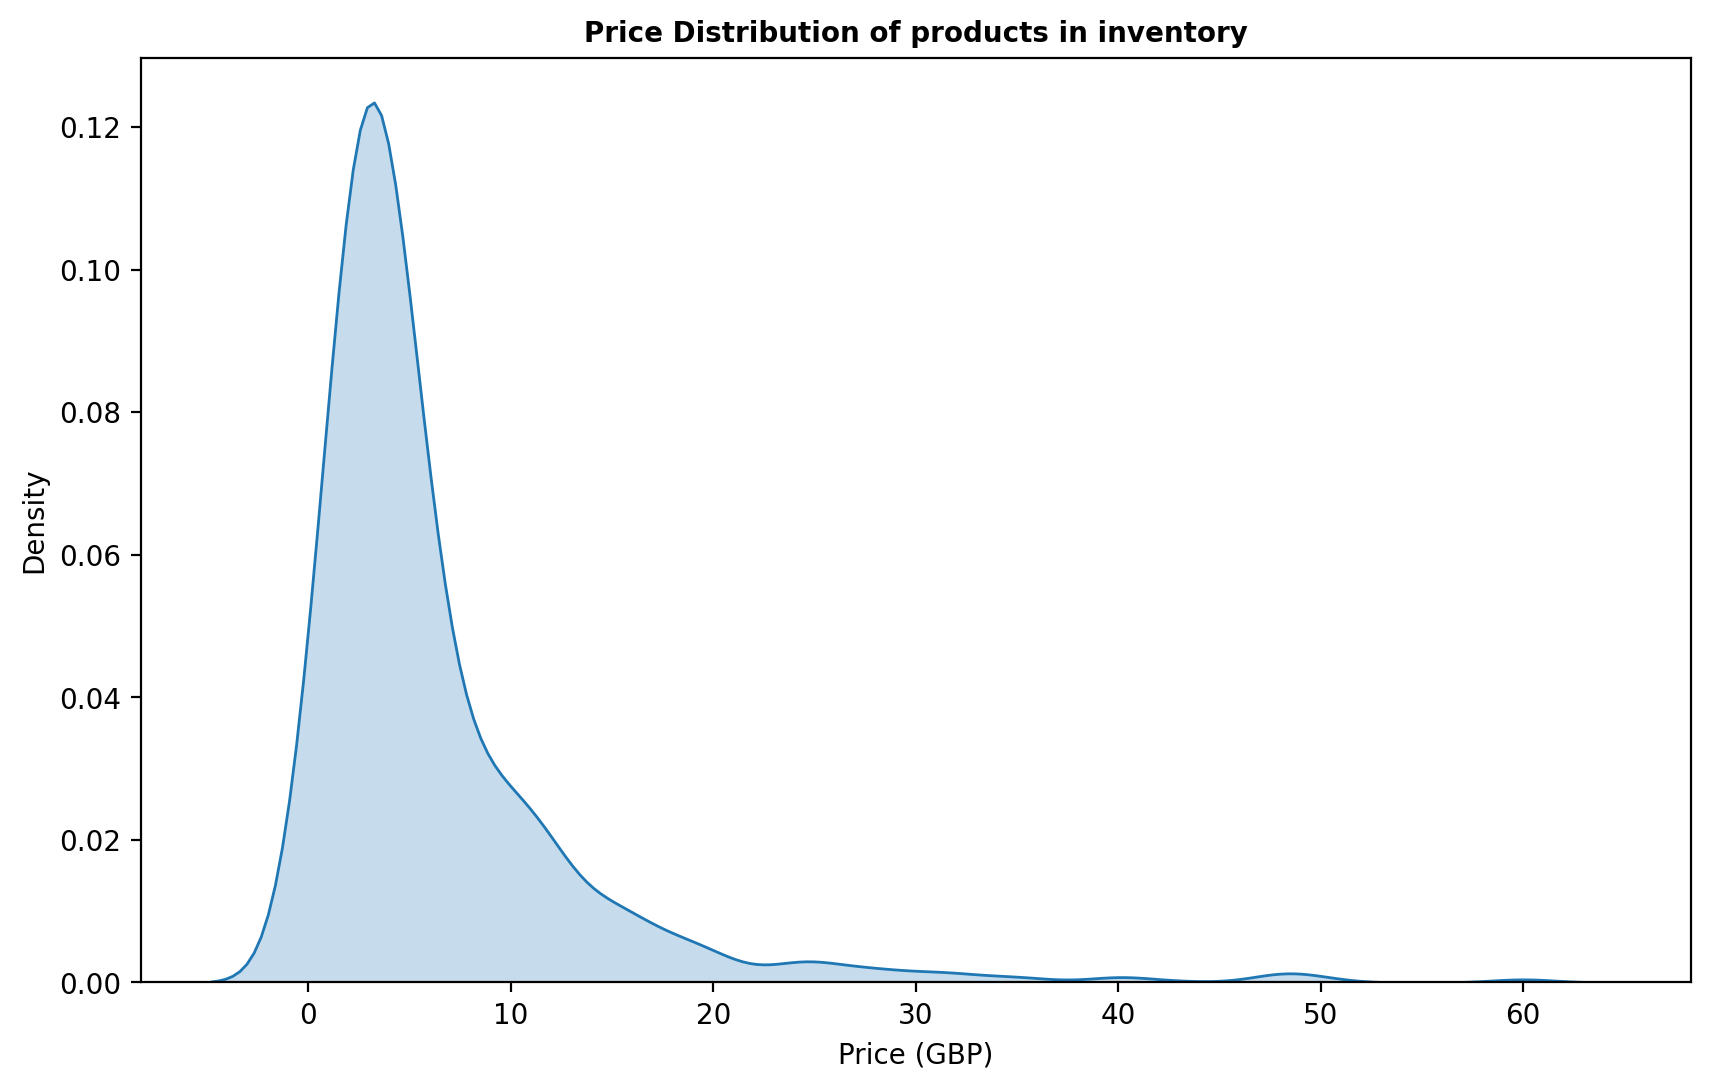

In [55]:


plt.figure(figsize=(10,6),dpi=200)
sns.kdeplot(data = inventory, x='price',fill=True)
plt.xlabel("Price (GBP)")
plt.ylabel("Density")
plt.title('Price Distribution of products in inventory',fontsize =10,fontweight = 'bold')

plt.show()



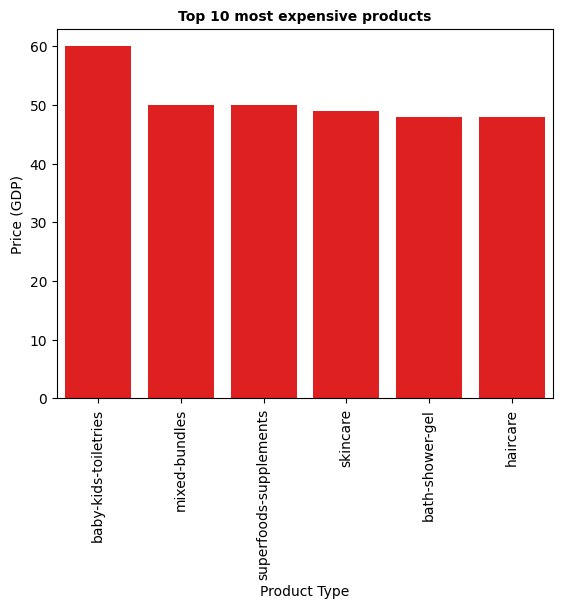

In [28]:
sns.barplot(data= inventory.sort_values(by='price', ascending=False).head(10), x='product_type', y='price', color='red')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Top 10 most expensive products', fontsize = 10, fontweight = 'bold')
plt.xlabel("Product Type")
plt.ylabel("Price (GDP)")
plt.show()

In [29]:
'''all_tags_lists = [tag for tags_list in inventory['tags'] for tag in tags_list]
all_tags_lists[:10]'''

"all_tags_lists = [tag for tags_list in inventory['tags'] for tag in tags_list]\nall_tags_lists[:10]"

In [30]:
all_tags = []
for list in inventory['tags']:
    for tag in list:
        all_tags.append(tag)

top_10_tags = pd.DataFrame(all_tags).value_counts().head(10)
'''top_10_tags'''

'top_10_tags'

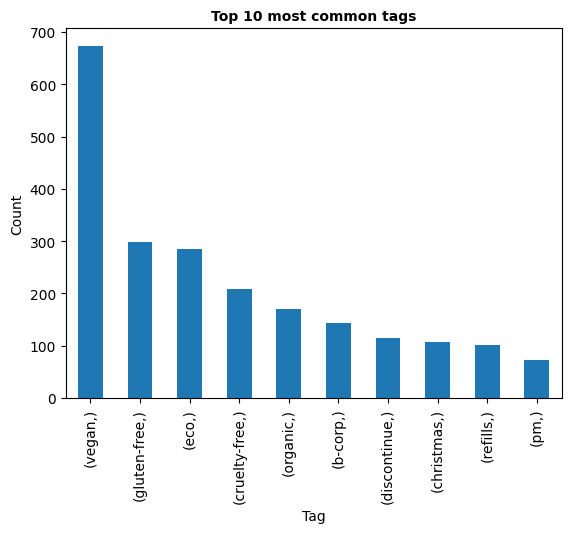

In [31]:
top_10_tags.plot.bar()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Top 10 most common tags', fontsize = 10, fontweight = 'bold')
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()

As we can see, we are a e-commerce specialized in vegan, eco, etc markets.